In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# Add the work folder shared with you into your My Drive by adding it as a shortcut before running this cell
%cd gdrive/MyDrive/work

Mounted at /content/gdrive
/content/gdrive/MyDrive/work


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly
from numpy import linalg as LA

# Gold Code Generator

This code takes in a satellite ID and returns its goldcode.

Reference: https://natronics.github.io/blag/2014/gps-prn/

In [2]:
SV = {
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}

def shift(register, feedback, output):
    """GPS Shift Register

    :param list feedback: which positions to use as feedback (1 indexed)
    :param list output: which positions are output (1 indexed)
    :returns output of shift register:

    """

    out = [register[i-1] for i in output]
    if len(out) > 1:
        out = sum(out) % 2
    else:
        out = out[0]

    fb = sum([register[i-1] for i in feedback]) % 2

    for i in reversed(range(len(register[1:]))):
        register[i+1] = register[i]

    register[0] = fb

    return out

def PRN(sv):

    """Build the CA code (PRN) for a given satellite ID

    :param int sv: satellite code (1-32)
    :returns list: ca code for chosen satellite

    """

    # init registers
    G1 = [1 for i in range(10)]
    G2 = [1 for i in range(10)]

    ca = [] # stuff output in here

    # create sequence
    for i in range(1023):
        g1 = shift(G1, [3,10], [10])
        g2 = shift(G2, [2,3,6,8,9,10], SV[sv]) # <- sat chosen here from table

        # modulo 2 add and append to the code
        ca.append((g1 + g2) % 2)

    # return C/A code!
    return ca

# Inverse GPS Signal Generator

This block of code loads the output tracking data generated by gnss-sdr and takes the I value from it and multiplies it with the gold code of that satellite, upsamples it and returns it.

NOTE!!!!
In this piece of code, we have multiplied the doppler shift with the upsampled PRN code. This is wrong as we are not taking into consideration about the phases of the actual samples which will be different. when correlating with the complex data, at some point far away the doppler would be 2pif_d *t/f_s wherease the prncode will have some different t, therefor giving wrong results as can be seen in the curve


In [3]:
# filepath = '/home/joel/gps-sdr-sim-master/gen_data_split/mydataa'
# data = np.fromfile(filepath,dtype = np.short)
# compdata = data[::2] + (1j)*data[1::2]
# sv = 15
# prn = PRN(sv)
# prn = [-1 if x == 0 else x for x in prn]

# prn_upsample = []
# n = 0
# for i in range(4000):
#     if ((i+1)/4000 <= (n+1)/1023):
#         prn_upsample.append(prn[n])
#     else:
#         n = n+1
#         prn_upsample.append(prn[n])
# # Doppler Shift
# doppler = {18 : 0, 12: 2697.905, 13: -2848.802, 10: 2891.328, 5: -2449.682, 15: -1816.517, 23: 2137.817}
# f_d = doppler[sv]

# n = np.arange(len(prn_upsample))
# prn_upsample = np.multiply(np.array(prn_upsample),np.exp(1j*2*np.pi*f_d*n/4000000))

# # Correlate the PRN code with the data
# prn_correlated = np.correlate(compdata[:50000],prn_upsample)
# indices = np.where(np.abs(prn_correlated) > 200000)[0]
# # print(indices)
# plt.plot(np.real(prn_correlated))
# plt.plot(np.imag(prn_correlated))
# plt.show()
# plt.plot(np.abs(prn_correlated))
# plt.show()

Here we have rectified the earlier mistake, we have multiplied the doppler with the corresponding complex data.

[ 3199  3200  3201  3202  3203  7198  7199  7200  7201  7202  7203 11199
 11200 11201 11202 11203 15199 15200 15201 15202 15203 19198 19199 19200
 19201 19202 19203 23199 23200 23201 23202 23203]


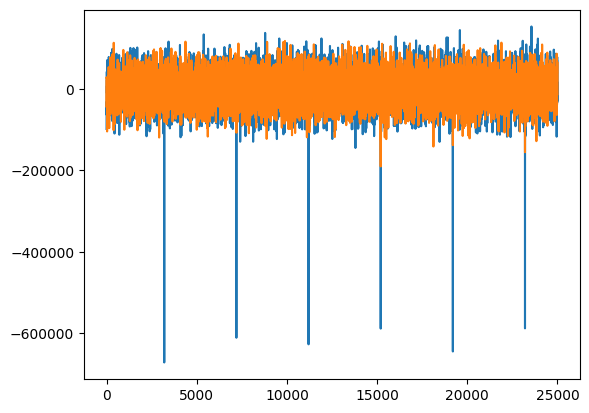

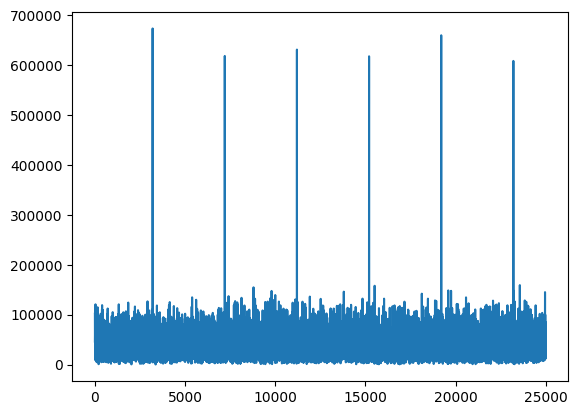

In [33]:
filepath = '/home/joel/gps-sdr-sim-master/gen_data_split/mydataa'
data = np.fromfile(filepath,dtype = np.short)
compdata = data[::2] + (1j)*data[1::2]
sv = 23


prn = PRN(sv)
prn = [-1 if x == 0 else x for x in prn]

prn_upsample = []
n = 0
for i in range(4000):
    if ((i+1)/4000 <= (n+1)/1023):
        prn_upsample.append(prn[n])
    else:
        n = n+1
        prn_upsample.append(prn[n])
# Doppler Shift
doppler = {18 : 0, 12: 2697.905, 13: -2848.802, 10: 2891.328, 5: -2449.682, 15: -1816.517, 23: 2137.817}
# f_d = doppler[sv]
f_d = doppler[sv]
n = np.arange(len(compdata[:100000]))
# prn_upsample = np.multiply(np.array(prn_upsample),np.exp(1j*2*np.pi*f_d*n/4000000))
compdata_shifted = np.multiply(compdata[:100000],np.exp(-1j*2*np.pi*f_d*n/4000000))
# Correlate the PRN code with the data
prn_correlated = np.correlate(compdata_shifted,prn_upsample)[:25000]
indices = np.where(np.abs(prn_correlated) > 200000)[0]
print(indices)
plt.plot(np.real(prn_correlated))
plt.plot(np.imag(prn_correlated))
plt.show()
plt.plot(np.abs(prn_correlated))
plt.show()

# Random String correlation

In [ ]:
l = [1,-1]
random_string = []
for i in range(6):
  random_string.append(np.random.choice(l))

In [ ]:
random_code = []
for i in range(len(random_string)):
  random_code.append(np.multiply(random_string[i],prn_upsample))
random_code = np.array(random_code).flatten()

In [ ]:
len(random_code)

24000

[]


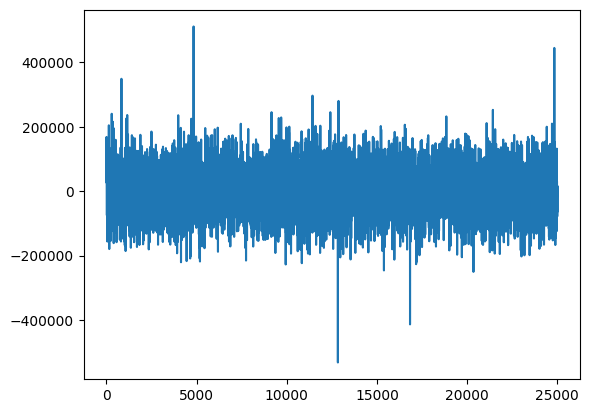

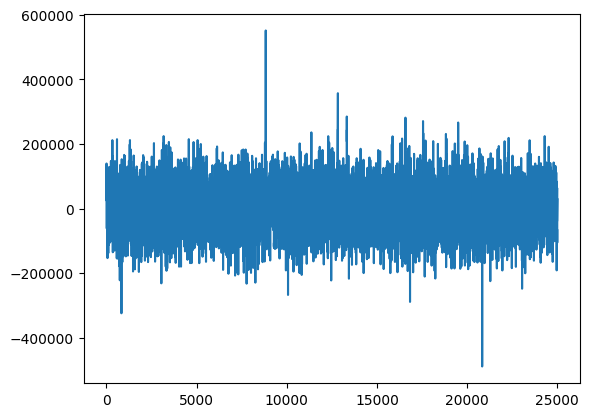

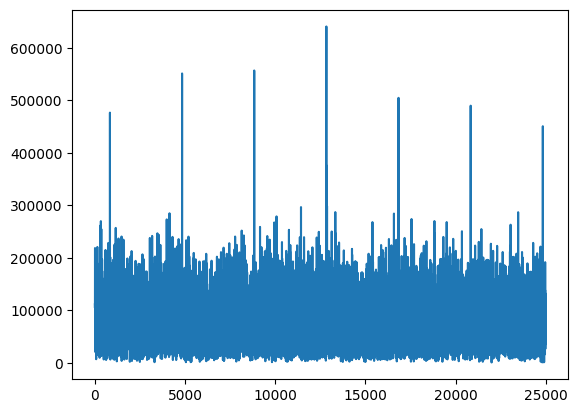

In [ ]:
n = np.arange(len(compdata[:100000]))
# prn_upsample = np.multiply(np.array(prn_upsample),np.exp(1j*2*np.pi*f_d*n/4000000))
compdata_shifted = np.multiply(compdata[:100000],np.exp(-1j*2*np.pi*f_d*n/4000000))
# Correlate the PRN code with the data
prn_correlated_1 = np.correlate(compdata_shifted,random_code)[:25000]
indices = np.where(np.abs(prn_correlated) > 500000)[0]
print(indices)
plt.plot(np.real(prn_correlated_1))
plt.show()
plt.plot(np.imag(prn_correlated_1))
plt.show()
plt.plot(np.abs(prn_correlated_1))
plt.show()

In [ ]:
subsetarr = []
for i in range(2400,2600):
  subsetarr.append(np.abs(prn_correlated[i]))

In [ ]:
# plt.plot(subsetarr,marker='o')

# Subtraction of satellite 18 data

In [4]:
# 10001011
filepath = '/home/joel/gps-sdr-sim-master/gen_data_split/mydataa'
data = np.fromfile(filepath,dtype = np.short)
compdata = data[::2] + (1j)*data[1::2]
sv = 23
prn = PRN(sv)
prn = [-1 if x == 0 else x for x in prn]

prn_upsample = []
n = 0
for i in range(4000):
    if ((i+1)/4000 <= (n+1)/1023):
        prn_upsample.append(prn[n])
    else:
        n = n+1
        prn_upsample.append(prn[n])
# Doppler Shift
doppler = {18 : 0, 12: 2697.905, 13: -2848.802, 10: 2891.328, 5: -2449.682, 15: -1816.517, 23: 2137.817}

In [5]:
gold_code = []
for i in range(20):
  gold_code.append(prn_upsample)
gold_code = np.array(gold_code).flatten()

In [6]:
code = [1,0,0,0,1,0,1,1]
v1 = []
for i in range(len(code)):
  if code[i] == 1:
    v1.append(np.array(gold_code))
  else:
    v1.append(np.multiply(-1,np.array(gold_code)))
v1 = np.array(v1).flatten()

In [7]:
f_d = doppler[sv]
n = np.arange(len(compdata[:2000000]))
compdata_shifted = np.multiply(compdata[:2000000],np.exp(-1j*2*np.pi*f_d*n/4000000))
# Correlate the PRN code with the data
# data_correlated = np.correlate(compdata_shifted,v1)

# plt.plot(np.abs(data_correlated))
# plt.show()

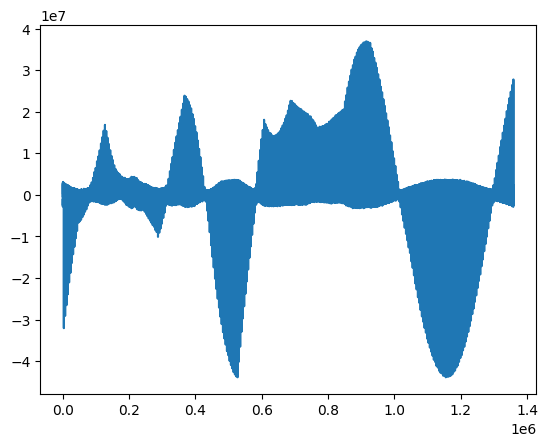

In [61]:
indices = np.where(np.abs(data_correlated) > 10000000)[0]
# print(indices)
plt.plot(np.real(data_correlated))
# plt.plot(np.imag(data_correlated))
plt.show()

In [ ]:
plt.plot(np.imag(data_correlated))

In [27]:
print(indices[:10])
print((data_correlated[indices[0]:indices[0]+10]))

[3198 3199 3200 3201 3202 3203 7198 7199 7200 7201]
[-13982884.13328465 +5242398.19261308j
 -23248331.22724136 +9285473.54216736j
 -32077576.81350427+13189395.25917181j
 -29796783.23574177+13344615.46448512j
 -20653668.31297846 +9485661.6075899j
 -11493742.54592695 +5533421.67028612j
  -2642359.99867687 +1702251.51262431j
    482292.91820653  -210046.25217244j
    410868.99028485  -310432.36399039j
    296747.60566035  -382041.74799624j]


In [8]:
# Select index: 3200 satellite 23
y = compdata_shifted[3200: 3200 + 640000]
x = v1
alp_est = np.dot(x.T, y)/np.dot(x.T,x)
print(alp_est)
# we know alpha = dot(y1,v1)/2norm(v1) - summation(dot(vi,v1)/2norm(v1))
# v1norm = LA.norm(v1)
# alpha = np.dot(compdata_shifted,v1)/v1norm
# print(alpha)
print(x.dtype)
print(y.dtype)
print(np.dot(x.T,x))

(-50.12121377110042+20.60843009245596j)
int64
complex128
640000


Now we will subtract using the estimated alpha value

In [9]:
yhat = y - alp_est*x
print(np.correlate(yhat,x))

[2.60770321e-08+5.12227416e-09j]


[753.12121377 -14.60843009j 128.13756433 -15.87038765j
 280.13617482 -19.15320068j ... -41.11953102+158.20192452j
 -49.34723034+309.12948816j 287.58529816+425.69892838j]
(200000,)


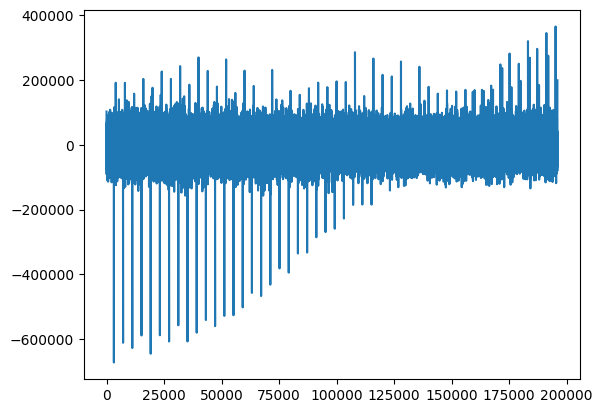

In [56]:
y1 = np.array(compdata_shifted[:200000])
t= alp_est*np.array(prn_upsample)
print(y1[4000*0: 4000])
t_repeated = np.tile(t,50)
y1 = y1 - t_repeated
cor = np.correlate(y1,prn_upsample)
plt.plot(np.real(cor))

In [7]:
import numpy as np
filepath = 'data/output_upd.dat'
data = np.fromfile(filepath,dtype = np.short)
compdata1 = data[::2] + (1j)*data[1::2]
print(compdata1[3200])

filepath = '/home/joel/gps-sdr-sim-master/gen_data_split/mydataa'
data = np.fromfile(filepath,dtype = np.short)
compdata2 = data[::2] + (1j)*data[1::2]
print(compdata2[3200])

for i in range(640000):
  if compdata1[3200+i] != compdata2[3200+i]:
    print(compdata1[3200+i],compdata2[3200+i])

(-133+160j)
(-133+160j)
(-245+6j) (-245+7j)
(-257-6j) (-257-7j)
(-467-52j) (-467-53j)
(-639-320j) (-639-321j)
(-460-455j) (-460-456j)
(-51-3j) (-52-3j)
(12+655j) (13+656j)
(-363+329j) (-363+330j)
(-119+369j) (-119+370j)
(-5+204j) (-6+204j)
(-45+191j) (-45+192j)
(139-301j) (139-302j)
(-18-53j) (-19-54j)
(364+337j) (364+338j)
(-29+728j) (-30+728j)
(975+537j) (976+537j)
(394+92j) (395+93j)
(263+173j) (263+174j)
(564+179j) (564+180j)
(951+92j) (952+93j)
(186+469j) (186+470j)
(198+399j) (198+400j)
(330+220j) (331+220j)
(330+218j) (330+219j)
(532+219j) (532+220j)
(21+22j) (22+23j)
(-301-8j) (-301-9j)
(-255+344j) (-256+344j)
(-468+129j) (-468+130j)
(248-93j) (249-94j)
(-511-37j) (-512-37j)
(-174-86j) (-175-86j)
(333-93j) (334-93j)
(-98+505j) (-99+506j)
(-468+332j) (-469+332j)
(74+93j) (74+94j)
(25+4j) (26+5j)
(-365+84j) (-366+85j)
(-19+354j) (-20+354j)
(131+349j) (132+349j)
(-390-13j) (-390-14j)
(-54-420j) (-55-420j)
(99-441j) (100-442j)
(-386+245j) (-387+246j)
(-103+162j) (-103+163j)
(26+76j